In [16]:
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import IQO, HybridCQN
from method.qnn import QuantumNeuralNetwork, CorrelatorQuantumNeuralNetwork
from utils.adapters import ResNetFeatures, MLPFeatures

from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch as tc
import matplotlib.pyplot as plt

In [17]:
bse = BlackScholes(eps=1e-10)
data = bse.generate_data()
data_teste = bse.generate_data(seed=42)
epochs = 1000
lr = 2e-2

In [18]:
model = MLP(neurons=4, M=5, activation=nn.Tanh())
opt = BlackScholeOptimizer(data, model, epochs=epochs, lr=lr)
loss = opt.train(return_loss=True)

Trainning: 100%|██████████| 1000/1000 [00:05<00:00, 173.92it/s]


In [19]:
res_model = ResNet(hidden=4, blocks=5, activation=nn.Tanh())
res_opt = BlackScholeOptimizer(data, res_model, epochs=epochs, lr=lr)
loss_ress = res_opt.train(return_loss=True)

Trainning: 100%|██████████| 1000/1000 [00:05<00:00, 170.29it/s]


In [20]:
qnn = QuantumNeuralNetwork(n_qubits=5, n_layers=4)
qpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
loss_qpinn= qpinn_opt.train(return_loss=True)

Trainning: 100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


In [21]:
cqnn = CorrelatorQuantumNeuralNetwork(n_qubits=3, n_layers=4, k=2, n_vertex=5)
cqpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=cqnn, classical_post=None), epochs=epochs, lr=lr)
loss_cqpinn= cqpinn_opt.train(return_loss=True)

Trainning: 100%|██████████| 1000/1000 [01:50<00:00,  9.07it/s]


In [22]:
cqnn_sem = CorrelatorQuantumNeuralNetwork(n_qubits=3, n_layers=4, k=2, n_vertex=5, nonlinear=None)
cqpinn_opt_sem = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=cqnn_sem, classical_post=None), epochs=epochs, lr=lr)
loss_cqpinn_sem= cqpinn_opt_sem.train(return_loss=True)

Trainning: 100%|██████████| 1000/1000 [01:43<00:00,  9.66it/s]


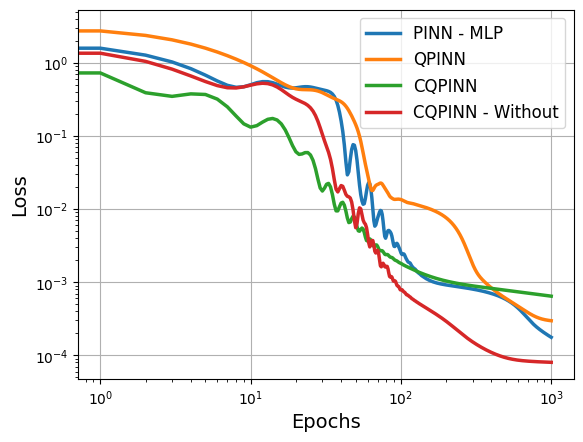

In [23]:
plt.plot(loss['Total'], lw=2.5,label='PINN - MLP')
#plt.plot(loss_ress['Total'], lw=2.5,label='PINN - ResNet')
plt.plot(loss_qpinn['Total'], lw=2.5,label='QPINN')
plt.plot(loss_cqpinn['Total'], lw=2.5,label='CQPINN')
plt.plot(loss_cqpinn_sem['Total'], lw=2.5,label='CQPINN - Without') 
#plt.plot(loss_hpinn['Total'], lw=2.5,label='HPINN - MLP')
#plt.plot(loss_hpinn_res['Total'], lw=2.5,label='HPINN - ResNet')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)
plt.show()

In [24]:
hpinn_res_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=ResNetFeatures(ResNet(hidden=4, blocks=1, activation=nn.Tanh())), qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
_, loss_hpinn_res = hpinn_res_opt.train(return_loss=True)

Trainning:   1%|          | 7/1000 [00:01<04:09,  3.98it/s]


KeyboardInterrupt: 

In [ ]:

hpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=MLPFeatures(MLP(neurons=4, M=1, activation=nn.Tanh())), qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
_, loss_hpinn = hpinn_opt.train(return_loss=True)

In [ ]:
opt.num_params, res_opt.num_params, qpinn_opt.num_params, hpinn_res_opt.num_params, hpinn_opt.num_params

In [ ]:
# Dictionary to store results for each method
results = {
    'PINN-MLP': {'losses': [], 'best_loss': float('inf'), 'best_history': None},
    'PINN-ResNet': {'losses': [], 'best_loss': float('inf'), 'best_history': None},
    'QPINN': {'losses': [], 'best_loss': float('inf'), 'best_history': None},
    'HPINN-MLP': {'losses': [], 'best_loss': float('inf'), 'best_history': None},
    'HPINN-ResNet': {'losses': [], 'best_loss': float('inf'), 'best_history': None}
}

n_iterations = 10
print(f"Training each model {n_iterations} times...")

for i in tqdm(range(n_iterations)):
    n_iterations = 10
    print(f"Training each model {i}...")
    # PINN-MLP
    model = MLP(neurons=4, M=5, activation=nn.Tanh())
    opt = BlackScholeOptimizer(data, model, epochs=epochs, lr=lr)
    _, current_loss = opt.train(return_loss=True)
    avg_loss = np.mean(current_loss['Total'][-100:])
    results['PINN-MLP']['losses'].append(current_loss['Total'])
    if avg_loss < results['PINN-MLP']['best_loss']:
        results['PINN-MLP']['best_loss'] = avg_loss
        results['PINN-MLP']['best_history'] = current_loss['Total']
    
    # PINN-ResNet
    res_model = ResNet(hidden=4, blocks=5, activation=nn.Tanh())
    res_opt = BlackScholeOptimizer(data, res_model, epochs=epochs, lr=lr)
    _, current_loss = res_opt.train(return_loss=True)
    avg_loss = np.mean(current_loss['Total'][-100:])
    results['PINN-ResNet']['losses'].append(current_loss['Total'])
    if avg_loss < results['PINN-ResNet']['best_loss']:
        results['PINN-ResNet']['best_loss'] = avg_loss
        results['PINN-ResNet']['best_history'] = current_loss['Total']
    
    # QPINN
    qnn = QuantumNeuralNetwork(n_qubits=4, n_layers=4)
    qpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=None, qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
    _, current_loss = qpinn_opt.train(return_loss=True)
    avg_loss = np.mean(current_loss['Total'][-100:])
    results['QPINN']['losses'].append(current_loss['Total'])
    if avg_loss < results['QPINN']['best_loss']:
        results['QPINN']['best_loss'] = avg_loss
        results['QPINN']['best_history'] = current_loss['Total']
    
    # HPINN-ResNet
    qnn = QuantumNeuralNetwork(n_qubits=4, n_layers=3)
    hpinn_res_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=ResNetFeatures(ResNet(hidden=4, blocks=2, activation=nn.Tanh())), 
                                                         qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
    _, current_loss = hpinn_res_opt.train(return_loss=True)
    avg_loss = np.mean(current_loss['Total'][-100:])
    results['HPINN-ResNet']['losses'].append(current_loss['Total'])
    if avg_loss < results['HPINN-ResNet']['best_loss']:
        results['HPINN-ResNet']['best_loss'] = avg_loss
        results['HPINN-ResNet']['best_history'] = current_loss['Total']
    
    # HPINN-MLP
    hpinn_opt = BlackScholeOptimizer(data, HybridCQN(classical_pre=MLPFeatures(MLP(neurons=4, M=1, activation=nn.Tanh())), 
                                                     qnn_block=qnn, classical_post=None), epochs=epochs, lr=lr)
    _, current_loss = hpinn_opt.train(return_loss=True)
    avg_loss = np.mean(current_loss['Total'][-100:])
    results['HPINN-MLP']['losses'].append(current_loss['Total'])
    if avg_loss < results['HPINN-MLP']['best_loss']:
        results['HPINN-MLP']['best_loss'] = avg_loss
        results['HPINN-MLP']['best_history'] = current_loss['Total']



In [ ]:
# Plot best losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for method in results:
    plt.plot(results[method]['best_history'], lw=2.5, label=f'{method}\n(Best={results[method]["best_history"][-1]:.2e})')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Best Loss History', fontsize=14)
plt.grid(True)

# Plot average losses with percentile bands
plt.subplot(1, 2, 2)
for method in results:
    losses_array = np.array(results[method]['losses'])
    median = np.median(losses_array, axis=0)
    q25 = np.percentile(losses_array, 25, axis=0)
    q75 = np.percentile(losses_array, 75, axis=0)
    
    plt.plot(median, lw=2.5, label=method)
    plt.fill_between(range(len(median)), q25, q75, alpha=0.2)

plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=10)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Median Loss with 25-75 Percentile Band', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
param_num =opt.num_params, res_opt.num_params, qpinn_opt.num_params, hpinn_res_opt.num_params, hpinn_opt.num_params

In [ ]:
param_num[0]

In [ ]:
teste = []
for i, method in enumerate(results):
    teste.append(results[method]["best_loss"]/param_num[i])
    print(f"{method}:", results[method]["best_loss"]/param_num[i], results[method]["best_history"][-1]/param_num[i])

print(teste/min(teste))

In [ ]:
# Print statistical summary
print("\nStatistical Summary (based on final 100 epochs average):")
for method in results:
    final_losses = np.array([np.mean(loss[-100:]) for loss in results[method]['losses']])
    q25, median, q75 = np.percentile(final_losses, [25, 50, 75])
    iqr = q75 - q25
    print(f"\n{method}:")
    print(f"Median: {median:.2e}")
    print(f"Q25-Q75: [{q25:.2e} - {q75:.2e}]")
    print(f"IQR: {iqr:.2e}")
    print(f"Stability (IQR/Median): {(iqr/median):.3f}")